Воссоздание решения уравнения Аллена-Кана из статьи: "Sifan Wang, Shyam Sankaran. Respecting causality is all you need for training physics-informed neural networks"
Ссылка на блокнот: https://github.com/PredictiveIntelligenceLab/CausalPINNs/blob/main/Allen_Cahn/AC.ipynb

d:\Учёба\adf\Скрипты\NN_pytorch_BVP\.venv\Lib\site-packages\torch\autograd\graph.py:841: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\cuda\CublasHandlePool.cpp:270.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


epoch =      1, loss_ic = 3.3238e-01, loss_r = 3.4140e-02
epoch =    100, loss_ic = 1.8437e-05, loss_r = 6.4945e-03
epoch =    200, loss_ic = 6.8895e-06, loss_r = 5.8481e-03
epoch =    300, loss_ic = 4.3728e-06, loss_r = 5.6319e-03
epoch =    400, loss_ic = 3.2720e-06, loss_r = 5.4199e-03
epoch =    500, loss_ic = 2.7269e-06, loss_r = 5.1767e-03
epoch =    600, loss_ic = 2.4213e-06, loss_r = 4.8895e-03
epoch =    700, loss_ic = 2.2243e-06, loss_r = 4.5415e-03
epoch =    800, loss_ic = 2.0820e-06, loss_r = 4.1129e-03
epoch =    900, loss_ic = 1.9713e-06, loss_r = 3.5866e-03
epoch =   1000, loss_ic = 1.8804e-06, loss_r = 2.9590e-03
epoch =   1100, loss_ic = 1.8012e-06, loss_r = 2.2587e-03
epoch =   1200, loss_ic = 2.3530e-05, loss_r = 1.7755e-03
epoch =   1300, loss_ic = 1.6453e-06, loss_r = 1.1268e-03
epoch =   1400, loss_ic = 1.5593e-06, loss_r = 6.7159e-04
epoch =   1500, loss_ic = 1.4868e-06, loss_r = 3.9806e-04
epoch =   1600, loss_ic = 1.4240e-06, loss_r = 2.6066e-04
epoch =   1700

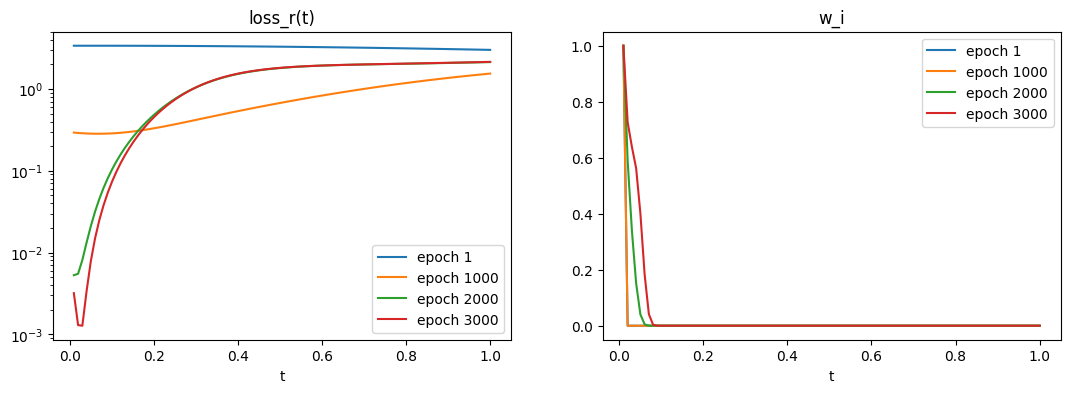

In [1]:
import time

import torch
import torch.optim as optim
import torch.nn as nn
import matplotlib.pyplot as plt
import matplotlib.tri as tri
import numpy as np

def initialize_weights(model, scheme):
    for layer in model.modules():
        if isinstance(layer, nn.Linear):
            if scheme == 'naive':
                nn.init.normal_(layer.weight, mean=0.0, std=1.0)
                if layer.bias is not None:
                    nn.init.normal_(layer.bias, mean=0.0, std=1.0)
            elif scheme == 'glorot_uniform':
                nn.init.xavier_uniform_(layer.weight)
                if layer.bias is not None:
                    nn.init.zeros_(layer.bias)
            elif scheme == 'glorot_normal':
                nn.init.xavier_normal_(layer.weight)
                if layer.bias is not None:
                    nn.init.zeros_(layer.bias)
            else:
                raise ValueError(f"{scheme} is an unknown scheme for weights initialization")

class PeriodicLayer(nn.Module):
    """
    Periodic feature mapping layer.

    This layer transforms selected input features into a periodic (Fourier-style) embedding.
    For each input feature `x_i` that is not in `keep_dims`, it produces the following features:

        [1, cos(ω_i*x_i), cos(2*ω_i*x_i), ..., cos(m*ω_i*x_i),
             sin(ω_i*x_i), sin(2*ω_i*x_i), ..., sin(m*ω_i*x_i)]

    Features specified in `keep_dims` are left unchanged and appended to the output.

    From the article "Sifan Wang, Shyam Sankaran: Respecting causality is all you need 
    for training physics-informed neural networks"

    Attributes:
        in_features (int): Number of input features.
        m (int): Number of harmonics (max multiplier for sine/cosine) for embedding.
        omega (list[float]): Frequency scaling for each input feature.
        keep_dims (list[int] or None): Indices of input features to leave unchanged.
        embed_dims (list[int]): Indices of input features to apply periodic embedding.
        _coeffs (torch.Tensor): Precomputed coefficients for embedding computation.
    """
    def __init__(self, in_features: int, m: int, omega: float | list[float], keep_dims: None | list[int] = None):
        """
        Initialize the PeriodicLayer.

        Args:
            in_features (int): Number of input features (dimensionality of input tensor).
            m (int): Number of harmonics to use for sine and cosine embeddings.
            omega (float or list of float): Frequency scaling. If a single float is provided, it is
                applied to all input features. If a list is provided, its length must equal `in_features`.
            keep_dims (list[int] or None, optional): Indices of input features that should
                be kept as-is (not transformed). Default is None (all features are transformed).
        """
        super().__init__()

        self.in_features = in_features
        self.m = m
        if isinstance(omega, (int, float)):
            self.omega = [omega] * in_features
        elif isinstance(omega, list):
            if len(omega) != in_features:
                raise ValueError("Length of omega list must equal in_features!")
            self.omega = omega[:]

        self.keep_dims = None if keep_dims is None else keep_dims[:]
        
        if keep_dims is None:
            embed_dims = list(range(in_features))
        else:
            embed_dims = [i for i in range(in_features) if i not in keep_dims]
            if len(embed_dims) == 0:
                raise ValueError("'keep_dims' list must not cover all the input features!")
        self.embed_dims = embed_dims

        self.register_buffer('_coeffs', torch.tensor([
            k * w for w in [self.omega[i] for i in self.embed_dims] 
            for k in range(1, self.m+1)]).reshape(1, -1))

        self.out_features = len(embed_dims) * (1 + 2*m)
        if  isinstance(self.keep_dims, list):
            self.out_features += len(self.keep_dims)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Forward pass of the PeriodicLayer.

        Args:
            x (torch.Tensor): Input tensor of shape `(batch_size, in_features)`.

        Returns:
            torch.Tensor: Output tensor with shape `(batch_size, output_features)` where
                `output_features = len(embed_dims) * (2*m + 1) + len(keep_dims)`.
                Contains periodic embeddings for selected features and raw values for `keep_dims`.
        """
        ones_tensor = x.new_ones((x.shape[0], len(self.embed_dims)))
        x_embed = x[:, self.embed_dims]
        x_rep = x_embed.repeat_interleave(self.m, dim=1)
        angles = x_rep * self._coeffs
        result = torch.cat( (ones_tensor, torch.cos(angles), torch.sin(angles)), dim=1 )
        if self.keep_dims is None:
            return result
        else:
            return torch.cat((result, x[:, self.keep_dims]), dim=1)

torch.manual_seed(2008)
device = 'cuda'
m = 10
omega = 2.0 * torch.pi / 2.0
domain = [0, -1, 1, 1]    # t_min, x_min, t_max, x_max
nt, nx = 100, 256
#n_epochs = 200000
n_epochs = 3000
lambda_ic, lambda_r = 100, 1
eps = 100

periodic_layer = PeriodicLayer(2, m=m, omega=omega, keep_dims=[0])
model = nn.Sequential(
    periodic_layer,
    nn.Linear(periodic_layer.out_features, 128), nn.Tanh(), 
    nn.Linear(128, 128), nn.Tanh(), 
    nn.Linear(128, 128), nn.Tanh(), 
    nn.Linear(128, 128), nn.Tanh(), 
    nn.Linear(128, 1)
).to(device=device)

initialize_weights(model, "glorot_normal")

def sample_points_2D(bounds: list[float], n: tuple, device: torch.device = torch.device("cpu")) -> torch.Tensor:
    """
    Generates a 2D grid of points.

    Args: 
        bounds (list[float]):
            A list of 4 floats with grid bounds: [x_min, y_min, x_max, y_max]
        n (tuple):
            A tuple of 2 integers: (nx, ny)
        device (torch.device):
            A PyTorch device to store output at

    Returns:
        xy (torch.tensor):
            A 2D tensor of shape (nx*ny, 2) where each row is a coordinate of a point
    """
    x_min, y_min, x_max, y_max = bounds
    nx, ny = n
    
    x = torch.linspace(x_min, x_max, nx, device=device)
    y = torch.linspace(y_min, y_max, ny, device=device)

    #X = x.repeat(ny)    # заполнять построчно 
    #Y = y.repeat_interleave(nx)
    X = x.repeat_interleave(ny)    # заполнять постолбцово
    Y = y.repeat(nx)

    return torch.stack([X, Y], dim=1)

tx = sample_points_2D(bounds=domain, n=(nt, nx), device=device)
tx_ic = tx[:nx, :].requires_grad_(True)
tx_r = tx[nx:, :].requires_grad_(True)

optimizer=torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9 ** (1.0 / 5000.0))
loss_r_arr = torch.zeros(n_epochs)
loss_ic_arr = torch.zeros(n_epochs)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 4))
ax1.set_title("loss_r(t)")
ax1.set_xlabel("t")
ax2.set_title("w_i")
ax2.set_xlabel("t")

training_start_time = time.time()
for epoch in range(1, n_epochs + 1):
    u_r = model(tx_r)
    u_ic = model(tx_ic)
    tmp = torch.autograd.grad(u_r, tx_r, grad_outputs=torch.ones_like(u_r), create_graph=True)[0]
    u_r_t = tmp[:, 0:1]
    u_r_x = tmp[:, 1:2]
    u_r_xx = torch.autograd.grad(u_r_x, tx_r, grad_outputs=torch.ones_like(u_r_x), create_graph=True)[0][:, 1:2]

    res_r = u_r_t - 0.0001*u_r_xx + 5*u_r**3 - 5*u_r
    res_ic = u_ic - tx_ic[:, 1:2]**2 * torch.cos(torch.pi*tx_ic[:, 1:2])

    # # Вычислить loss_r_per_t для заданной эпохи
    # loss_r_per_t = torch.stack([
    #     torch.mean(res_r[i*nx:(i+1)*nx]**2)
    #     for i in range(nt-1)
    # ])

    # cumulative = torch.cumsum(loss_r_per_t, dim=0) - loss_r_per_t
    # w_i = torch.exp(-eps * cumulative).detach()
    
    # #loss_r = torch.mean( res_r**2 )
    # loss_r = torch.dot(w_i, loss_r_per_t) / (nt-1)
    r_grid = res_r.view(nt-1, nx)             # if you truly exclude t=0
    L_t = r_grid.pow(2).mean(dim=1)           # (nt-1,)
    M = torch.tril(torch.ones(nt-1, nt-1, device=device), diagonal=-1)
    W = torch.exp(-eps * (M @ L_t.detach()))
    loss_r = (W * L_t).mean()

    loss_ic = torch.mean( res_ic**2 )
    loss = lambda_ic * loss_ic + lambda_r * loss_r
    loss.backward()
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()
    loss_r_arr[epoch-1] = loss_r.detach().cpu()
    loss_ic_arr[epoch-1] = loss_ic.detach().cpu()

    if epoch in [1, 1000, 2000, 3000]:
        ax1.semilogy(tx_r[0::nx, 0].detach().cpu(), L_t.detach().cpu(), label=f"epoch {epoch:d}")
        ax2.plot(tx_r[0::nx, 0].detach().cpu(), W.detach().cpu(), label=f"epoch {epoch:d}")
        #plt.plot(w_i.detach().cpu())
        #plt.plot(W.detach().cpu())
    
    if epoch == 1 or epoch % 100 == 0:
        print(f"epoch = {epoch:6d}, loss_ic = {loss_ic_arr[epoch-1]:10.4e}, loss_r = {loss_r_arr[epoch-1]:10.4e}")

training_time = time.time() - training_start_time
print(f"Training took {int(training_time) // 3600} hour(s), " 
      f"{ (int(training_time) % 3600) // 60 } minute(s) and "
      f"{ (training_time % 3600) % 60:.2f} second(s)")
ax1.legend()
ax2.legend()
plt.show()

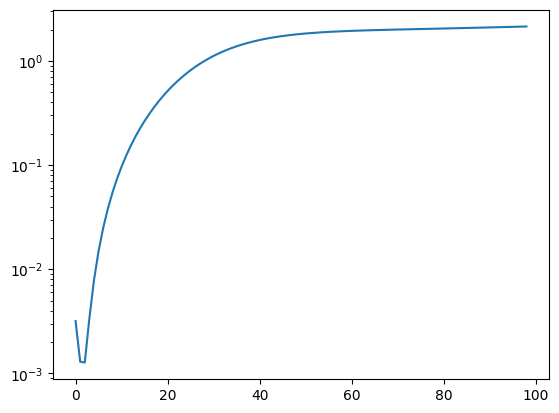

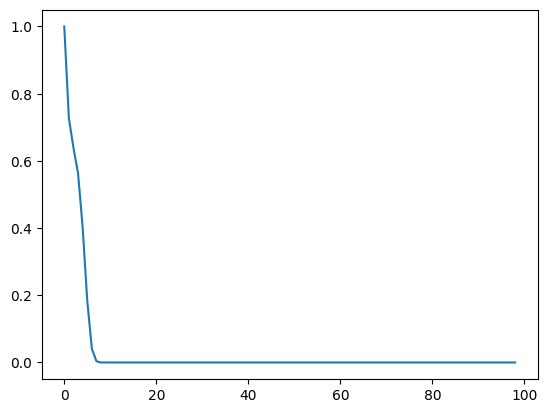

In [2]:
#loss_r_per_t = loss_r_per_t.detach().cpu()
#plt.semilogy(loss_r_per_t)
#plt.show()
plt.semilogy(L_t.detach().cpu())
plt.show()

#plt.plot(w_i.detach().cpu())
plt.plot(W.detach().cpu())
plt.show()

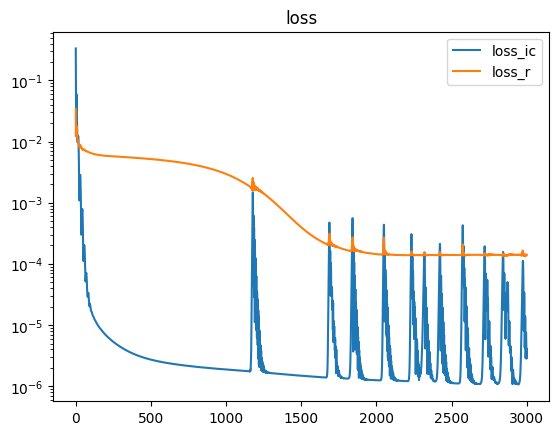

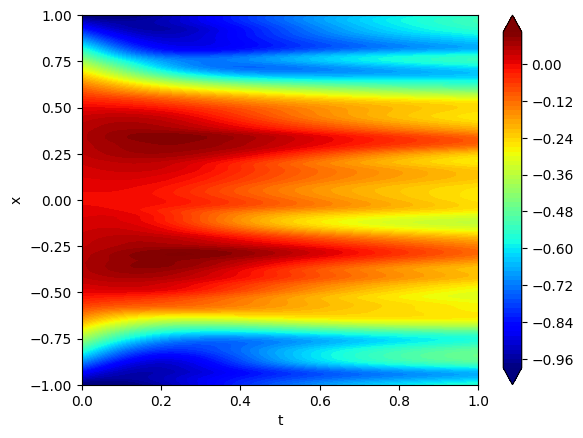

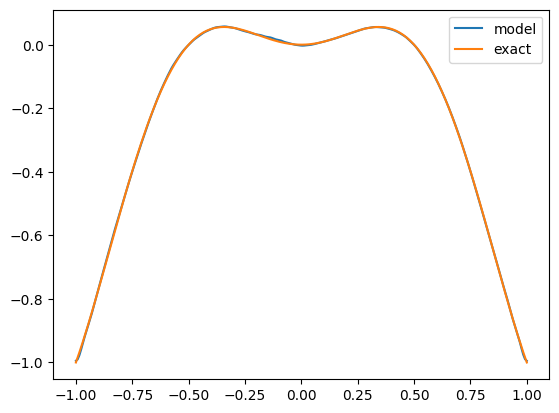

In [3]:
with torch.no_grad():
    plt.semilogy(loss_ic_arr, label="loss_ic")
    plt.semilogy(loss_r_arr, label="loss_r")
    plt.legend()
    plt.title("loss")
    plt.show()

    model = model.to('cpu')
    tx = tx.to('cpu')
    tx_ic = tx_ic.to('cpu')

    fig, ax = plt.subplots()
    triang = tri.Triangulation(tx[:, 0], tx[:, 1])
    tcf = plt.tricontourf(triang, model(tx).squeeze(), levels=80, extend='both', cmap='jet')
    fig.colorbar(tcf)
    plt.xlabel("t")
    plt.ylabel("x")
    plt.show()

    plt.plot(tx_ic[:, 1:2], (model(tx_ic)).squeeze(), label="model")
    plt.plot(tx_ic[:, 1:2], (tx_ic[:, 1:2]**2 * torch.cos(torch.pi*tx_ic[:, 1:2])).squeeze(), label="exact")
    plt.legend()
    plt.show()